# Transaction Dependency Analysis and Foata Normal Form

Maciej Wiśniewski GR 9 Śr 8.00

This notebook analyzes dependencies between transactions, calculates the Foata Normal Form (FNF), and visualizes the dependency graph.
Implementation in Python, visualization in matplotlib, graphs shown with networkx.

To run execute all cells from nootebook, networkx and matplotlib are required

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import Dict, List, Set, Tuple

Loading data from txt files. 
Example alphabet format in alfabet.txt file, example transactions format in transakcje.txt file

In [2]:
def load_transactions(file_path: str) -> Dict[str, List[str]]:
    with open(file_path, encoding='utf8') as file:
        text = file.read()
    
    transactions = {}
    
    for line in text.split('\n'):
        if not line.strip(): continue
            
        open_idx = line.find('(')
        close_idx = line.find(')', open_idx + 1)
        
        if open_idx == -1 or close_idx == -1: continue  
        trans_name = line[open_idx + 1:close_idx]
        variables = [char for char in line[close_idx + 1:] if 'a' <= char <= 'z']
        transactions[trans_name] = variables
    
    return transactions


def load_alphabet(file_path: str) -> List[str]:
    with open(file_path, encoding='utf8') as file: text = file.read()
    alphabet = [char for char in text if 'a' <= char <= 'z']
    
    return sorted(alphabet)

Validating input

In [ ]:
def validate_input(transactions: Dict, alphabet: List[str], word: str) -> bool:
    
    if sorted(list(transactions.keys())) != alphabet: 
        raise ValueError("Alphabet does not match transaction labels")
    
    for char in word:
        if char not in alphabet: 
            raise ValueError(f"Unknown transation in word: '{char}'")
        
    return True

Determining dependency relations

calculate_dependent_pairs -  Calculates the dependency relation D. Two transactions are dependent if they operate on the same variable (specifically if one writes to a variable used by the other).

calculate_relations - Calculates dependency relation D and independence relation I

create_dependency_dict - Creates a dependency dictionary for each transaction.

In [ ]:
def calculate_dependent_pairs(transactions: Dict) -> Set[Tuple[str, str]]:
    dependent = set()
    keys = list(transactions.keys())
    
    for trans1 in keys:
        left_var = transactions[trans1][0] if transactions[trans1] else None
        
        if not left_var: continue
        for trans2 in keys:
            if left_var in transactions[trans2]:
                dependent.add((trans1, trans2))
                dependent.add((trans2, trans1))
    
    return dependent


def calculate_relations(transactions: Dict, alphabet: List[str]):
    all_pairs = [(a1, a2) for a2 in alphabet for a1 in alphabet]

    dependent_set = calculate_dependent_pairs(transactions)
    independent_set = set(all_pairs) - dependent_set
    
    return sorted(list(dependent_set)), sorted(list(independent_set))


def create_dependency_dict(dependent_pairs: List[Tuple], alphabet: List[str]):
    dep_dict = {trans: set() for trans in alphabet}
    
    for trans1, trans2 in dependent_pairs:
        dep_dict[trans1].add(trans2) if trans1!= trans2 else None
    return dep_dict

Foata Normal Form Algorithm

Implementation based of https://www.researchgate.net/publication/280851316_Partial_Commutation_and_Traces p11

In [ ]:
def foata_normal_form_algorithm(dep_dict: Dict, word: str, alphabet: List[str]):
    # Initialize stacks (shafts)
    stacks = {trans: [] for trans in alphabet}
    
    # Fill stacks iterating backwards through the word
    for trans in reversed(word):
        stacks[trans].append(1)  # mineral - actual transaction occurrence
        for dependent_trans in dep_dict[trans]:
            stacks[dependent_trans].append(0)  # waste - dependency
    
    fnf = []
    
    # extract minerals layer by layer
    while True:
        minerals = extract_minerals(stacks)
        if not minerals:
            break
        
        fnf.append(minerals)
        
        # Remove waste markers from dependent transactions
        for mineral in minerals:
            for dependent_trans in dep_dict[mineral]:
                if stacks[dependent_trans]:
                    stacks[dependent_trans].pop()
    
    return fnf


def extract_minerals(stacks: Dict) -> List[str]:
    minerals = []
    
    for trans, stack in stacks.items():
        if stack and stack[-1] == 1:
            stack.pop()
            minerals.append(trans)
    
    return minerals

Building dependency graph

calculate_graph_edges - Calculates the minimal dependency graph edges. Applies transitive reduction to remove redundant edges.

prepare_graph_visuals - Moving graph to networkx

In [ ]:
def calculate_graph_edges(dep_dict: Dict, word: str) -> Set[Tuple[int, int]]:
    n = len(word)
    edges = set()
    for i in range(n - 1):
        for j in range(i + 1, n):
            if word[j] in dep_dict[word[i]] or word[i] == word[j]:
                edges.add((i + 1, j + 1))
    to_remove = set()
    for i in range(1, n):
        for j in range(i + 1, n + 1):
            if (i, j) in edges:
                for k in range(j + 1, n + 1):
                    if (i, k) in edges and (j, k) in edges: to_remove.add((i, k))
    
    return edges - to_remove


def prepare_graph_visuals(word: str, edges: Set) -> Tuple:
    G = nx.DiGraph()

    nodes = {i + 1: f"{word[i]}{i}" for i in range(len(word))}
    G.add_nodes_from(nodes.values())
    graph_edges = [(nodes[u], nodes[v]) for u, v in edges]
    G.add_edges_from(graph_edges)
    
    positions = {f"{word[i]}{i}": [(-1) ** (i + 1), 1 - i // 2]
                  for i in range(len(word))}
    labels = {f"{word[i]}{i}": word[i] for i in range(len(word))}
    
    return G, positions, labels

Displaying analysis results and plotting visualization

In [ ]:
def display_relations(dependent: List, independent: List):
    print("\n" + "DEPENDENCY RELATION" + "\n")
    print("D = {", end="")
    print(", ".join(f"({a},{b})" for a, b in dependent), end="")
    print("}")
    print("\n" + "INDEPENDENCE RELATION" + "\n")
    print("I = {", end="")
    print(", ".join(f"({a},{b})" for a, b in independent), end="")
    print("}")

def display_dot_graph(word: str, edges: Set):
    print("\n" + "GRAPH IN DOT FORMAT" + "\n")
    print("digraph g {")
    
    for u, v in sorted(edges, key=lambda k: (k[1], k[0])): print(f"  {u} -> {v}")
    print()
    for i in range(len(word)): print(f"  {i + 1} [label={word[i]}]")
    print("}")

def display_fnf(fnf: List):
    print("\n" + "FOATA NORMAL FORM" + "\n")
    print("FNF([w]) = ", end="")
    for cls in fnf:
        print("(", end="")
        print("".join(sorted(cls)), end="")
        print(")", end="")
    print()

def draw_graph(G, positions, labels, word: str):
    plt.figure(figsize=(10, 8), num=f"Dependency Graph for word: {word}")
    
    nx.draw(G,positions,labels=labels, with_labels=True, node_size=690, node_color='lightblue', font_size=12,
             font_weight='bold',arrows=True,  arrowsize=18,connectionstyle="arc3,rad=0.15", edge_color='gray')
    
    plt.title(f"Minimal Dependency Graph\nWord: {word}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Main function - executing all the steps of analysis

In [ ]:
def analyze_transactions(trans_file: str, alphabet_file: str, word: str):  
    # Load data
    transactions = load_transactions(trans_file)
    alphabet = load_alphabet(alphabet_file)
    
    # Validate data
    if  validate_input(transactions, alphabet, word) == None:
         raise ValueError("Input validation failed")
    
    # Calculate relations
    dependent, independent = calculate_relations(transactions, alphabet)
    display_relations(dependent, independent)
    
    # Calculate FNF
    dep_dict = create_dependency_dict(dependent, alphabet)
    fnf = foata_normal_form_algorithm(dep_dict, word, alphabet)
    display_fnf(fnf)
    
    # Caluculate graph edges
    edges = calculate_graph_edges(dep_dict, word)
    display_dot_graph(word, edges)
    
    # Draw graph
    G, positions, labels = prepare_graph_visuals(word, edges)
    draw_graph(G, positions, labels, word)
    print("\n")

Run for example test 1:


DEPENDENCY RELATION

D = {(a,a), (a,b), (a,c), (b,a), (b,b), (b,d), (c,a), (c,c), (c,d), (d,b), (d,c), (d,d)}

INDEPENDENCE RELATION

I = {(a,d), (b,c), (c,b), (d,a)}

FOATA NORMAL FORM

FNF([w]) = (b)(ad)(a)(bc)

GRAPH IN DOT FORMAT

digraph g {
  1 -> 2
  2 -> 3
  1 -> 4
  3 -> 5
  4 -> 5
  3 -> 6
  4 -> 6

  1 [label=b]
  2 [label=a]
  3 [label=a]
  4 [label=d]
  5 [label=c]
  6 [label=b]
}


C:\Users\macie\AppData\Local\Temp\ipykernel_20108\4119287714.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


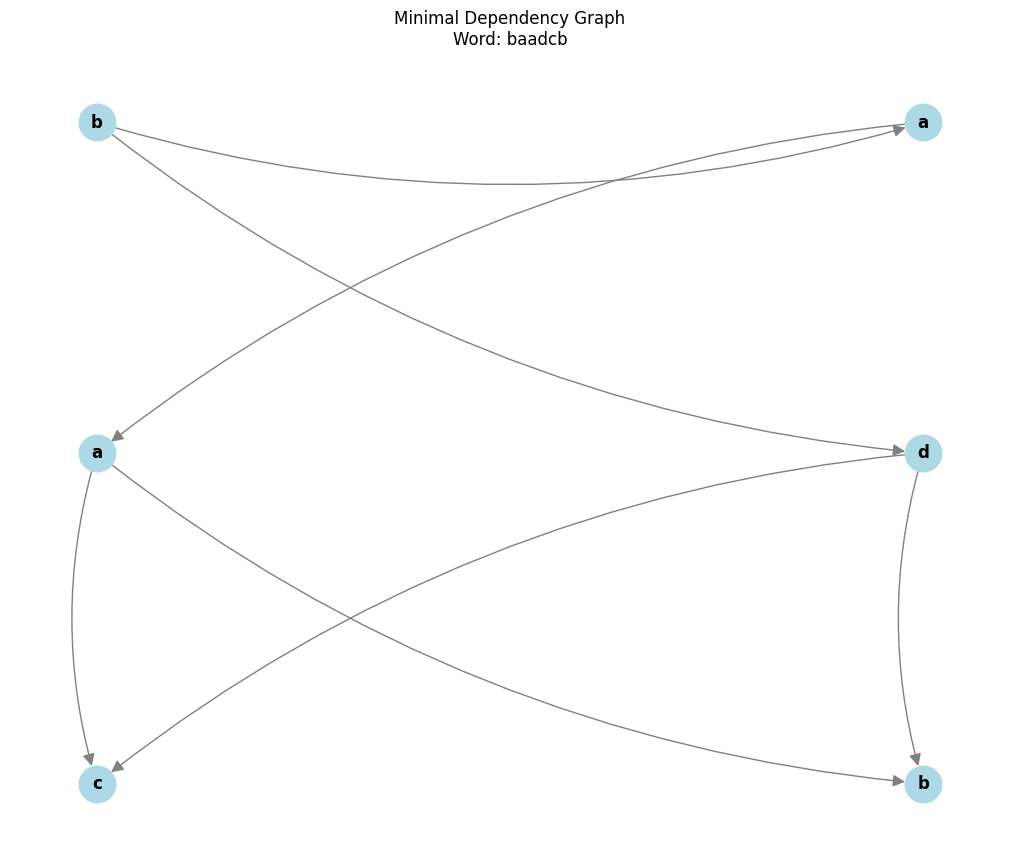

In [63]:
analyze_transactions('transakcje.txt', 'alfabet.txt', 'baadcb')

All results are matching with results from task description

Run for example test 2


DEPENDENCY RELATION

D = {(a,a), (a,c), (a,f), (b,b), (b,e), (c,a), (c,c), (c,e), (c,f), (d,d), (d,f), (e,b), (e,c), (e,e), (f,a), (f,c), (f,d), (f,f)}

INDEPENDENCE RELATION

I = {(a,b), (a,d), (a,e), (b,a), (b,c), (b,d), (b,f), (c,b), (c,d), (d,a), (d,b), (d,c), (d,e), (e,a), (e,d), (e,f), (f,b), (f,e)}

FOATA NORMAL FORM

FNF([w]) = (abd)(bc)(c)(ef)

GRAPH IN DOT FORMAT

digraph g {
  1 -> 2
  2 -> 4
  3 -> 5
  4 -> 5
  6 -> 7
  4 -> 8
  7 -> 8

  1 [label=a]
  2 [label=c]
  3 [label=d]
  4 [label=c]
  5 [label=f]
  6 [label=b]
  7 [label=b]
  8 [label=e]
}


C:\Users\macie\AppData\Local\Temp\ipykernel_20108\4119287714.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


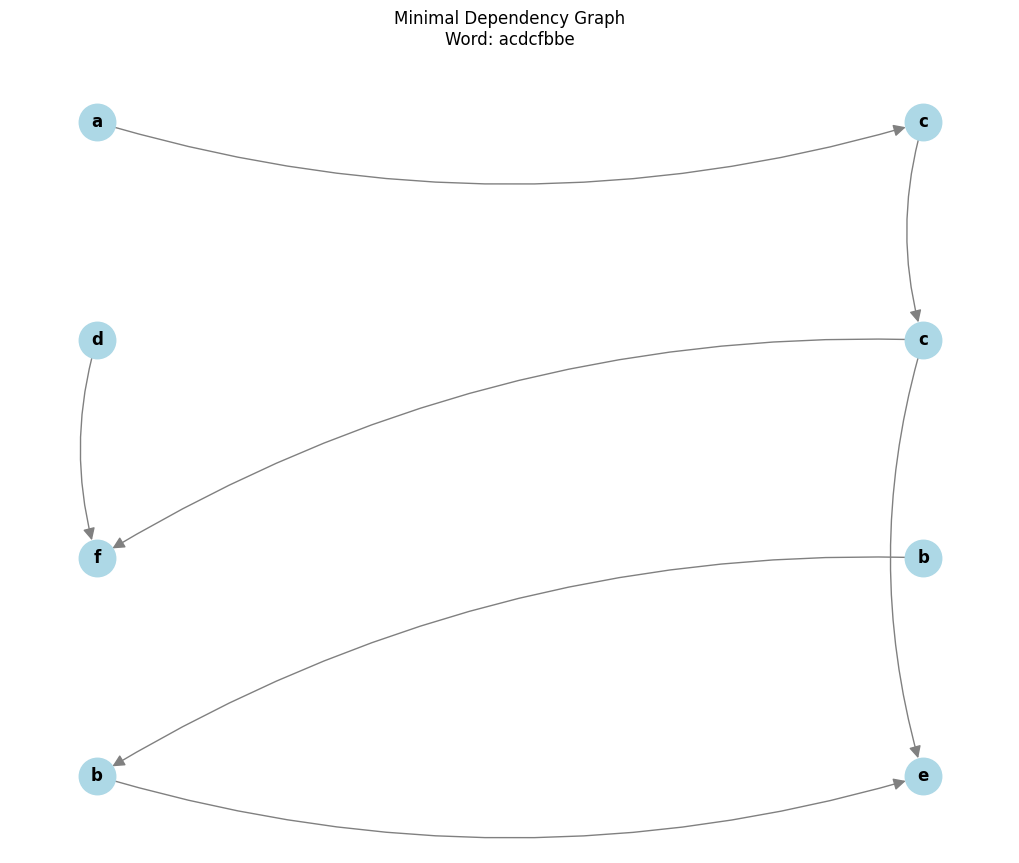

In [64]:
analyze_transactions('transakcje2.txt', 'alfabet2.txt', 'acdcfbbe')